# Tutorial: Optimization

# Part 1: Convex and Linear Optimization

## Optimization Basics, Convexity and Classification
### Exercise 1: Optimization Problem Statement

Formally state an optimization problem for a space engineering scenario: Minimize fuel consumption ($f(\mathbf{x}) = \mathbf{c}^\top \mathbf{x}$) for a satellite maneuver, subject to thrust limits ($\mathbf{A} \mathbf{x} \leq \mathbf{b}$) and energy balance ($\mathbf{h}(\mathbf{x}) = 0$). Identify degrees of freedom and classify as LP or NLP. Discuss both model development and complexity with your colleagues.

HINT: You don't have to write out the full model in order to compute the DoF for the physics inside the energy balances and thurst relations, but it might be worth your time to look at those models from the chapters on simulation.

### Exercise 2: Convexity (shapes)

Classify the following shapes as convex or non-convex:


<img src="../images/7_0_shapes.svg"
     alt="A collection of convex and non-convex geometric shapes"
     width="500">
<br>

HINT: Remember the formal definition of convexity: if you pick any points $a, b \in \mathcal{X}$ and draw a line between them then it should not intersect with the boundary of the shape. In this case the domain $\mathcal{X}$ is the interior of the shape.


### Exercise 3: Convexity (functions)

1. Prove that the function $f(x) = x^2$ is convex using the definition. For the nonconvex $f(x) = x^4 - 3x^2$, find points where the line segment intersects the curve.
2. The code below modifies the chapter's ipywidgets code to test new functions, e.g., $f(x) = e^x$ (convex) vs. $f(x) = \sin(x)$ (nonconvex). Propose two new functions -one convex and one non-convex- then test

In [171]:
import numpy as np

def test_integrated_moment_sphere(R=1.0, num_sectors=6):
    # Total dual area of the vertex
    total_dual_area = 0.1
    area_per_sector = total_dual_area / num_sectors

    # Vertex at the North Pole
    v_i = np.array([0, 0, R])

    minkowski_area = 0.0

    for _ in range(num_sectors):
        # 1. Exact Integrated Curvature Normal for this sector
        # On a sphere, H = 1/R, and for a small patch, n is approx v_i/R
        # K_if = Integrate[ H * n ] dA
        K_if = (v_i / R**2) * area_per_sector

        # 2. Sector Barycenter
        # Even if the curvature is 'exact', the position x in -<x, Hn>
        # must be the centroid of where that curvature is distributed.
        # For a small sector, the offset from the vertex is O(h)
        offset = np.array([np.random.uniform(-0.01, 0.01),
                           np.random.uniform(-0.01, 0.01), 0])
        c_if = v_i + offset

        # 3. The Moment Sum
        minkowski_area -= np.dot(c_if, K_if)

    print(f"Calculated Area: {minkowski_area:.16f}")
    print(f"Expected Area:   {total_dual_area:.16f}")
    print(f"Error:           {abs(minkowski_area - total_dual_area):.2e}")

test_integrated_moment_sphere()

Calculated Area: -0.1000000000000000
Expected Area:   0.1000000000000000
Error:           2.00e-01


### Exercise 4: Problem classification and standard form

Classify the following three problems, then write them in standard form (in other words, write in a form that should be accepted by a solver, but do not solve in code):

1. Minimize the objective function $x_1 + 2 x_2$ subject to the constraint $4 x_1 + 6 x_2 \le 10$ and bounded from below ($x_1, x_2 \ge 0$).
2. Maximize the objective $ - 3^3 x_1 - x_2$ subject to the set of constraints $\mathbf{g(x)} = \left\{ x_1 + x_2 \le 1, x_1 \le 1, -x_2 \le -3 \right\}$.
3. Minmize the objective function $f(\mathbf{x}) = 2 x_1^2 + x_1 x_2 + 2 x_2^2 $ with boundaries $x_1 \in \left[-1.5, 1.5 \right]$ and $x_2 \in \left[-2, 2 \right]$.

In [ ]:
x

## Linear programming (LP)

### Excercise 5: Linear Programming with Simplex, IPM, and HiGHS

In this excercise we will implement and compare LP solvers on a higher-dimensional problem, emphasizing computational efficiency.

Problem Setup: Consider a higher-dimensional LP inspired by space mission resource allocation: Maximize weighted payload value for a spacecraft fleet subject to constraints on fuel, crew hours, volume, and total mass. The derived model is:

$$\begin{align*}
\max \quad & 5x_1 + 4x_2 + 3x_3 + 2x_4 \\
\text{subject to} \quad & 2x_1 + x_2 + 3x_3 + x_4 \leq 10, \\
& x_1 + 2x_2 + x_3 + 3x_4 \leq 12, \\
& 3x_1 + x_2 + 2x_3 + 2x_4 \leq 11, \\
& x_1 + x_2 + x_3 + x_4 \leq 5, \\
& x_1, x_2, x_3, x_4 \geq 0.
\end{align*}
$$

Here, $x_1, x_2, x_3, x_4$ represent masses allocated to four modules with different values (e.g., scientific instruments prioritized higher). This is a 4-variable, 4-constraint LP (higher-dimensional than the 2D example).

1. Practice converting this to standard form by hand, before coding. You can validate your solution by computing $\mathbf{c}^\top \mathbf{x}$ and comparing with the benchmark solutions below (i.e. you should get that $\mathbf{c}^\top \mathbf{x} = 23.00$ for your solution $\mathbf{x}$.


2. Implement the objective and constraints in code. Solve using scipy.optimize.linprog with:

- 'revised simplex',
- 'interior-point',
- 'highs'.

Benchmark each solver using timeit or similar and compare runtimes (run multiple iterations for accuracy). Plot or print optima and discuss differences (if any).

3. Discuss the comparison of solver times, due to differences in your machine build and back-end libraries you might get different results, discuss if the result below are in line with our expectations from the lectures:

```
Method: revised simplex:
- Optimal value: 23.00,
- x: [3. 2. 0. 0.],
- Time: 0.002612 s

Method: interior-point
- Optimal value: 23.00
- x: [3.00000000e+00 2.00000000e+00 2.34280548e-11 4.72679422e-12]
- Time: 0.002060 s

Method: highs
- Optimal value: 23.00,
- x: [3. 2. 0. 0.]
- Time: 0.001106 s
```

A visual comparison of the benchmark times for the three solvers can be found in the bar graph below:

<img src="../images/7_1_LP_results.png"
     alt="Benchmark times for 3 LP solvers"
     width="500">
<br>

## Quadratic programming

### (Optional) Exercise 6: Quadratic Programming and Least-Squares

In this exercise we will implement a basic QP problem

Problem Formulation: Consider a basic QP problem for portfolio optimization: Minimize the risk (quadratic variance) of a two-asset portfolio while achieving a target return, subject to budget constraints. Formally:$$\begin{align*}
\min \quad & x_1^2 + 0.5 x_1 x_2 + x_2^2 - 2x_1 - 3x_2 \\
\text{subject to} \quad & x_1 + x_2 = 1, \\
& x_1, x_2 \geq 0.
\end{align*}$$

Here, $x_1, x_2$ are investment fractions in two assets.

1. Rewrite this in standard QP matrix form (identify $\mathbf{Q}$, $\mathbf{c}$, equality constraints) by hand. Discuss why it's convex (check Hessian).
2. Implement the objective and constraints in Python. Solve using scipy.optimize.minimize with 'SLSQP' (Sequential Least Squares Programming, suitable for constrained QP). Print the optimum and verify against unconstrained solution.

HINT: For validation your solution should be $f^* = -2.04$ at $ x_1 = 0.17$ and $x_2 = 0.83$. You can additionally validate the solution by plotting slices of the objective funciton in the $x_1$ and/or $x_2$ planes.

## Linear least squares

### Exercise 7: Linear Least-Squares (40 minutes)

In this excercise we will solve an overdetermined system via least-squares and visualize noisy data fitting. First we geenerate synthetic noisy data for a quadratic regression model, then we will fit parameters to polynomial $y = a x^2 + b x + c$ from 20 noisy measurements over $x \in [0, 10]$. The code snippet below does for an _underlying_ model $y = 0.1 x^2 + 2 x + 1$ with Gaussian noise added using `np.random.normal` (you can confirm visualy what this noise looks like using e.g. `plt.hist`)

1. Discuss how this connects overdetermined equations ($m=20 > n=3$) to optimization ($\min \| \mathbf{A} \mathbf{x} - \mathbf{y} \|_2^2$).
2. Python Implementation: Create the design matrix $\mathbf{A}$ (columns: $x^2, x, 1$), add Gaussian noise to true $y = 0.1 x^2 + 2 x + 1$, solve with np.linalg.lstsq, and plot data vs. fit. Compute residuals and discuss fit quality.
3. Adjust the noise levels and resolve the problem, comment on the difference between the solutions to the underlying coefficients.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy data
x = np.linspace(0, 10, 20)
true_y = 0.1 * x**2 + 2 * x + 1
noise = np.random.normal(0, 1, len(x))  # Gaussian noise
y = true_y + noise
y

## Convex optimization

### (Optional) Exercise 8: Local convexity and penalty constraints

The code below is taken from the lecture notes problem to minimize $f(x) = x^2 + \sin(2\pi x)$. It should be noted that of course this function is _not_ globally convex, however, there are local basins of attraction where the problem is locally convex.

1. Define the subdomains $[x_l, x_u] \in [-1.5, 2] \in \mathcal{X}$ where the objective function $f$ is locally convex (either rigorously or just select the domains by hand).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define f and grad_f (missing in your snippet!)
def f(x):
    return x**2 + np.sin(2 * np.pi * x)

def grad_f(x):
    return 2*x + 2*np.pi*np.cos(2*np.pi*x)

def gd_demo(alpha=0.01, x_start=1.5):
    x = x_start
    history = [x]
    for _ in range(100):
        x -= alpha * grad_f(x)
        history.append(x)

    x = np.linspace(-2, 2, 1000)
    plt.figure(figsize=(8, 5))  # Added for clarity
    plt.plot(x, f(x), label='$f(x)$')
    plt.plot(history, f(np.array(history)), 'ro-', label='GD Path')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'GD with α={alpha}, start={x_start}')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(gd_demo, alpha=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01),
         x_start=FloatSlider(min=-2, max=2, step=0.1, value=1.5));

#### Penalty Functions

We already saw with the IPM method how penalty barrier methods can be used to constrain and/or guide the optimization routine towards a desired solution. Such **penalty barrier** methods are useful constructions that allow us to improve our optimizations. For example, suppose that in the above function only care about finding the global minimum around $x^* \approx -0.25$. In order to reliably find the value of the objective  $f^* = f(x^*)$ (for any starting value $x_0$ and/or $\alpha$ value) we can implement penalty barriers in a locally convex domain $x \in [x_l, x_u]$ as follows:

$$ \min f_p (\mathbf x) := f (\mathbf x) + ~ \sum_{i\in I} p_i ~  g(c_i(\mathbf x)) $$

where

$g(c_i(\mathbf x))=\max(0,c_i(\mathbf x ))^2$

In the above equations, $g(c_i(\mathbf x))$  is the penalty function while $p$ is called a penalty coefficient. The coefficients must be tuned so that they are aggressive" enough to ensure convexity without making the final problem too ill-conditioned to solve. These kind of methods have the advantage that faster unconstrained GD methods can be used to solve the problem while the disadvantage is the possibility of breaking the solver by making the constraints too aggressive.

As an example of what these functions look like in 1D see the simplified functions plotted below:



In [ ]:
import numpy as np
import matplotlib.pyplot as plt  # Optional for visualization

# Define our global X domain
xspan = np.linspace(-2, 2, 100)

# Define our local domain we want to focus on:
x_u = 0.5
x_l = -0.5

# Define parameters for our penalty functions
p_1 = 1
p_2 = 1

# Define the penalty functions:
def g_1(x):
    return p_1 * np.maximum(0, xspan - x_u)**2
def g_2(x):
    return p_2 * np.maximum(0, -(xspan - x_l))**2


# Plot to visualize
plt.plot(xspan, g_1(xspan), label=f'Upper bound $x_u ={x_u}$, $g_i = max(0, x - x_u)^2$')
plt.plot(xspan, g_2(xspan), label=f'Lower bound $x_l ={x_l}$, $g_i = max(0, x - x_u)^2$')
plt.xlabel('x')
plt.ylabel('Result')
plt.title('Vectorized Computation')
plt.legend()
plt.grid(True)
plt.show()

Note that the function is above is zero for our region of interest $x \in [x_l, x_u]$ so that the final solution is unaffected by the barriers. Feel free to play with the the parameters $p_1$, $p_2$ to get a feeling for how much this affects the gradient of the barriers.

2. Now implement your own custom penalty functions as constraints so that you can redefine the objective function and obtain a new function that is globally convex. Use the the $x_l, x_u$ pair that you found in the first part of the question to define your barrier penalties.


|

### (Optional) Exercise 9: Gradient-Descent Exploration

Experiment with GD on multimodal functions.

1. Use the definition Lipschitz continuity and explain why it affects step size in GD.
2. Identify local vs. global minima in the 2D example from the lecture notes (you can also use the code below) within the domain $[0, 1] \times [0, 1] \in\mathcal{X} $ by using different starting values and then printing the solution given by the optimizer.
3. In the code below we added momentum (modify update to $\mathbf{v}_{k+1} = \beta \mathbf{v}_k - \alpha \nabla f$, $\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{v}_{k+1}$ ($\beta=0.9$)) to the python multimodal demonstrations from the lecture notes. Try different starts ($\alpha = 0.01$) and note basins. Try to add your own objective function with shallower basins of attraction.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


# Extend chapter's gd_demo or multimodal widget
def gd_with_momentum(start_x1, start_x2, alpha=0.01, beta=0.9, max_iters=100):
    x = np.array([start_x1, start_x2])
    v = np.zeros(2)
    path = [x.copy()]
    for _ in range(max_iters):
        grad = grad_f(*x)  # From chapter
        v = beta * v - alpha * grad
        x += v
        path.append(x.copy())
    return np.array(path)


min_x = 0
min_y = 0

# Define the multimodal function and gradient
def f(x1, x2):
    return np.sin(3 * np.pi * x1) + np.sin(3 * np.pi * x2) + 0.1 * (x1**2 + x2**2)

def grad_f(x1, x2):
    df_dx1 = 3 * np.pi * np.cos(3 * np.pi * x1) + 0.2 * x1
    df_dx2 = 3 * np.pi * np.cos(3 * np.pi * x2) + 0.2 * x2
    return np.array([df_dx1, df_dx2])

# GD function
def run_gd(start_x1, start_x2, alpha, max_iters=100):
    x = np.array([start_x1, start_x2])
    path = [x.copy()]
    for _ in range(max_iters):
        grad = grad_f(*x)
        x -= alpha * grad
        path.append(x.copy())
        if np.linalg.norm(grad) < 1e-4:
            break
    return np.array(path)

# Interactive plot
def plot_gd(start_x1=0.5, start_x2=0.5, alpha=0.01):
    #path = run_gd(start_x1, start_x2, alpha)
    path = gd_with_momentum(start_x1, start_x2, alpha)
    # Contour plot
    x1 = np.linspace(min_x, 1.5, 200)
    x2 = np.linspace(min_y, 1.5, 200)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)

    plt.figure(figsize=(8, 6))
    plt.contour(X1, X2, Z, levels=20, cmap='viridis', alpha=0.7)
    plt.colorbar(label='f(x1, x2)')
    plt.plot(path[:, 0], path[:, 1], 'r-', marker='o', markersize=3, label='GD Path')
    plt.scatter(path[0, 0], path[0, 1], color='green', s=100, label='Start')
    plt.scatter(path[-1, 0], path[-1, 1], color='black', s=100, label='End')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Gradient Descent on Multimodal Function')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(plot_gd,
         start_x1=FloatSlider(min=min_x, max=1.5, step=0.05, value=0.7, description='Start x1:'),
         start_x2=FloatSlider(min=min_y, max=1.5, step=0.05, value=0.6, description='Start x2:'),
         alpha=FloatSlider(min=0.001, max=0.05, step=0.001, value=0.01, description='Alpha:'));



# Integrate into plot_gd function

Discussion: How do starting points affect convergence in nonconvex space trajectory optimization?

# Part 2: Nonlinear Programming (NLP)

## Excercise 1: KKT Conditions Verification

Verify KKT conditions symbolically and graphically for a simple constrained NLP. Consider the NLP: Minimize $f(x, y) = (x - 1)^2 + (y - 1)^2$ subject to $g(x, y) = x^2 + y^2 - 0.5 \leq 0$.

1. Use SymPy to compute the KKT system (primal/dual feasibility, stationarity, complementarity). Solve for the KKT point and multipliers.
2. Modify the Matplotlib code from the chapter to plot the objective contours, feasible region, and gradients at the KKT point. Verify stationarity visually.
3. Discuss why this satisfies the conditions and its relevance (e.g., optimizing satellite sensor placement under power constraints).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import sympy as sp
# Part a: SymPy
x, y, lam = sp.symbols('x y lambda')
f = (x - 1)**2 + (y - 1)**2
g = x**2 + y**2 - 0.5
# ... (complete as in chapter)

# Part b: Plot (adapt chapter code)

## Exercise 2: Trust-Region Methods on Rosenbrock
Implement and analyze a basic trust-region algorithm. Use the Rosenbrock function $f(x, y) = 100(y - x^2)^2 + (1 - x)^2$.

1. Modify the chapter's NumPy trust-region code to track trust radius $\delta_k$ over iterations. Run from initial point $(-1.2, 1)$.
2. Plot the iteration path on contours and the radius evolution. Experiment with different $\eta_0, \eta_1$ (e.g., tighter thresholds) and discuss convergence (e.g., how it handles the "banana" valley, analogous to non-linear trajectory optimization).


In [ ]:
# Adapt chapter's rosenbrock and trust_region_opt functions
# Add delta tracking: deltas = [delta0]
# In loop: deltas.append(delta_k)
# Plot: plt.plot(deltas)

## Exercise 3: SQP for Constrained Optimization

Apply SQP to an engineering-inspired problem. Model a simplified thrust allocation: Minimize $f(\mathbf{u}) = \mathbf{u}^\top \mathbf{u}$ (energy) for thrusts $\mathbf{u} = [u_1, u_2]$, subject to $\mathbf{A} \mathbf{u} = \mathbf{\tau}$ (force balance, equality) and $u_1^2 + u_2^2 \leq 1$ (non-linear limit), with $\mathbf{A} = [[1,1],[1,-1]]$, $\mathbf{\tau} = [1, 0.5]$, bounds $|u_i| \leq 0.8$.

1. Use scipy.optimize.minimize(method='SLSQP') to solve. Provide Jacobians if possible for efficiency.
2. Plot the feasible region, constraints, and solution. Discuss active constraints and KKT relevance (e.g., in spacecraft attitude control).

Stub Code:

In [ ]:
# Adapt chapter's objective, constraints
res = minimize(objective, u0, method='SLSQP', bounds=bounds, constraints=constraints)
# Plot: Use plt.fill for circle constraint, lines for equalities

## (Optional) Exercise 3b: Solving NLPs with scipy.optimize.minimize

Extra practice with NLPs using SciPy. Implement and solve NLPs using SciPy, covering bounds, inequality/equality constraints, and parameter tuning. This explores full solver inputs on a toy problem mimicking resource allocation (e.g., optimizing spacecraft power distribution).

1. Define an NLP: Minimize $f(x) = (x_1 - 1)^2 + \sin^2(x_2)$ subject to equality $x_1 + x_2 = 1$, inequality $x_1^2 + x_2^2 \leq 5$, and bounds $x_1, x_2 \geq 0$. Use minimize(method='SLSQP') to solve from initial point $\mathbf{x} = [0.5, 0.5]$.
2. Modify key parameters: Change method to 'trust-constr', add Jacobians (compute symbolically with SymPy if needed), experiment with tolerance (tol=1e-8), and max iterations (maxiter=200). Plot the solution on contours and discuss changes (e.g., convergence speed).
3. Discuss how constraints affect the minimum vs. unconstrained case.

Starter code (contains solution to 1):

## Exercise 4: Non-Linear Least-Squares Fitting

In this exercise we fit a non-linear model to noisy data. Simulate orbital decay data: $r(t) = r_0 e^{-\beta t} + \epsilon$, with noisy measurements (e.g., satellite altitude over time).

1. Generate synthetic data ($r_0=1000, \beta=0.01$) and use scipy.optimize.least_squares to fit parameters.
2. Plot data, true model, and fit. Add bounds (e.g., $\beta > 0$) and discuss Jacobian usage. Relate to estimating drag coefficients from telemetry.
3. Compare to linear least-squares from Chapter 7.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Data generation: Simulate orbital decay data r(t) = r0 * exp(-beta * t) + epsilon
# True parameters: r0 = 1000 km (initial altitude), beta = 0.01 (decay rate)
np.random.seed(42)  # For reproducibility
t = np.linspace(0, 100, 50)  # Time points (e.g., days)
r0_true = 1000
beta_true = 0.01
epsilon = 5 * np.random.randn(len(t))  # Noise (e.g., measurement error in km)
r_noisy = r0_true * np.exp(-beta_true * t) + epsilon

# Residual function for NLLS
def residuals(params, t, r):
    r0, beta = params
    return #TODO: complete this line

# Initial guess
params0 = [900, 0.005]

# Solve NLLS with bounds (r0 > 0, beta > 0)
bounds = ([0, 0], [np.inf, np.inf])
res = least_squares(residuals, params0, args=(t, r_noisy), bounds=bounds, method='trf')  # Trust-region reflective

print("Fitted parameters [r0, beta]:", res.x)
print("Residual sum of squares:", res.cost)

# Plot
r_fit = res.x[0] * np.exp(-res.x[1] * t)
plt.scatter(t, r_noisy, label='Noisy data')
plt.plot(t, r0_true * np.exp(-beta_true * t), 'k--', label='True model')
plt.plot(t, r_fit, 'r-', label='Fitted model')
plt.xlabel('Time t (days)')
plt.ylabel('Altitude r (km)')
plt.title('NLLS Fit: Orbital Decay')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 5: SGD with Momentum on Noisy 1D Function

Compare SGD (with/without momentum) to a deterministic solver on a noisy loss landscape mimicking NN training.
Define a 1D noisy function $f(x) = (x-2)^2 + 0.5 \sin(10x) + \epsilon$ (big valley with local minima, noise $\epsilon \sim \mathcal{N}(0,0.1)$).

1. [Practice only; solution below] Implement SGD with optional momentum. Use ipywidgets for sliders: learning rate (0.01–0.1), momentum $\beta$ (0–0.99), epochs (100–1000). Plot path and evaluations.
2. Compare to minimize (e.g., 'BFGS' for deterministic). Count evaluations (via callback) and discuss how momentum speeds convergence by escaping local minima.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.optimize import minimize

# Noisy function and gradient
def noisy_func(x, sigma=0.1):
    return (x - 2)**2 + 0.5 * np.sin(10 * x) + sigma * np.random.randn()

def grad_noisy(x, sigma=0.1):
    return 2*(x - 2) + 5 * np.cos(10 * x) + sigma * np.random.randn()

# SGD with momentum
def sgd_1d(x0, lr=0.01, beta=0.0, epochs=100, sigma=0.1, tol=1e-3):
    x = x0
    v = 0
    path = [x]
    evals = 0
    x_prev = np.inf
    for _ in range(epochs):
        g = grad_noisy(x, sigma)
        v = beta * v + (1 - beta) * g
        x -= lr * v
        path.append(x)
        evals += 1  # Each grad call is an eval
        #print(f'abs(x - x_prev) = {abs(x - x_prev) }')
        if abs(x - x_prev) < tol:
            break
        else:
            x_prev = x

    return np.array(path), evals

# Deterministic function (noise-free)
def det_func(x):
    return (x - 2)**2 + 0.5 * np.sin(10 * x)

def det_grad(x):
    return 2*(x - 2) + 5 * np.cos(10 * x)

# Deterministic solver (BFGS, without or without noise) with path
def det_solver(x0, noisy=True, jac=True):
    path = [np.array([x0])]
    eval_count = 0
    def callback(xk):
        path.append(xk.copy())
        nonlocal eval_count
        eval_count += 1

    if noisy:
        if jac:
            jac_func = grad_noisy
        else:
            jac_func = None

        res = minimize(noisy_func, np.array([x0]), jac=grad_noisy, method='BFGS', callback=callback)
    else:
        res = minimize(det_func, np.array([x0]), jac=det_grad, method='BFGS', callback=callback)

    print(f'BFGS results: {res}')
    eval_count = res.nfev
    return res.x[0], np.array(path)[:, 0], eval_count

# Interactive plot with subplots
def interactive_sgd(x0=-1.0, lr=0.05, beta=0.9, max_epochs=500, sigma=0.1):
    path_sgd, evals_sgd = sgd_1d(x0, lr, beta, max_epochs, sigma)
    x_opt_det, path_det, evals_det = det_solver(x0)

    x_vals = np.linspace(-1, 4, 200)
    y_vals = det_func(x_vals)  # Noise-free for plot
    y_noisy_overlay = det_func(x_vals) + sigma * np.random.randn(len(x_vals))  # Noisy overlay, no fixed seed

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # SGD subplot
    axs[0].plot(x_vals, y_noisy_overlay, color='gray', alpha=0.7, label='Noisy overlay')
    axs[0].plot(x_vals, y_vals, 'k-', alpha=0.3, label='Noise-free f(x)')
    axs[0].plot(path_sgd, noisy_func(path_sgd, sigma=0), 'tab:red', marker='o', label='SGD Path', markersize=4)
    axs[0].plot(path_sgd[-1], noisy_func(path_sgd[-1], sigma=0), 'x', color='tab:red',label=f'Final SGD: $f({path_sgd[-1]:.2f}) = {det_func(path_sgd[-1]):.2f}$ ', markersize=10)
    axs[0].set_title(f'SGD ({evals_sgd} evals)')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('f(x)')
    axs[0].legend()
    axs[0].grid(True)

    # BFGS subplot
    axs[1].plot(x_vals, y_noisy_overlay, color='gray', alpha=0.7, label='Noisy overlay')
    axs[1].plot(x_vals, y_vals, 'k-', alpha=0.3, label='Noise-free f(x)')
    axs[1].plot(path_det, det_func(path_det), 'tab:blue', marker='o', label='BFGS Path', markersize=4)
    axs[1].plot(x_opt_det, det_func(x_opt_det), 'x', color='tab:blue',label=f'Final BFGS: $f({x_opt_det:.2f})  = {det_func(x_opt_det):.2f}$ ', markersize=10)
    axs[1].set_title(f'BFGS ({evals_det} evals)')
    axs[1].set_xlabel('x')
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle('SGD vs. BFGS on Noisy/Non-Linear Function')
    plt.show()

interact(interactive_sgd, x0=FloatSlider(min=-2.0, max=2.0, step=0.1, value=-1.0),
         lr=FloatSlider(min=0.01, max=0.1, step=0.01, value=0.05),
         beta=FloatSlider(min=0.0, max=0.99, step=0.05, value=0.9),
         max_epochs=IntSlider(min=100, max=1000, step=100, value=500),
         sigma=FloatSlider(min=0.0, max=0.5, step=0.05, value=0.1))

## (Optional) Exercise 5: Integrating Backprop and SGD in NNs

In this exercise train a NN with SGD and momentum on a dataset. Use the non-linear function fitting from Section 8.7.4.
1. Modify the NumPy backprop code to use mini-batch SGD with momentum ($\beta=0.9$). Split data into batches of 32.
2. Plot loss curves with/without momentum. Integrate scikit-learn's MLPRegressor (with 'sgd' solver) for comparison.
3. Discuss why momentum helps (e.g., in training NNs for control policies).

In [ ]:
# Adapt forward/backprop from chapter
# For SGD: Randomly sample batches in loop
# Add velocity v = [np.zeros_like(p) for p in theta]
# Update: v[i] = beta * v[i] + (1 - beta) * grads[i]; theta[i] -= lr * v[i]

# scikit-learn: from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(10,5), solver='sgd', momentum=0.9)
mlp.fit(x, y.ravel())

In [ ]:
def test_sphere_precision(R=1.0, num_vertices=100):
    # Mock data for a sphere
    # Area = 4 * pi * R^2
    true_area = 4 * np.pi * (R**2)

    # Simulate discrete dual areas that sum to total area
    individual_area = true_area / num_vertices

    minkowski_total = 0.0
    for i in range(num_vertices):
        # Generate random point on sphere
        phi = np.random.uniform(0, 2*np.pi)
        cos_theta = np.random.uniform(-1, 1)
        theta = np.arccos(cos_theta)

        pos = R * np.array([
            np.sin(theta) * np.cos(phi),
            np.sin(theta) * np.sin(phi),
            np.cos(theta)
        ])

        # In a sphere, H = 1/R, n = pos/R.
        # Integrated Hn over dual area Ai is (1/R * pos/R) * Ai
        hn_integrated = (pos / R**2) * individual_area

        # Minkowski term: - <pos, hn_integrated>
        # Note: For a closed sphere, boundary_sum is 0
        minkowski_total -= np.dot(pos, hn_integrated)

    error = abs(minkowski_total + true_area)
    print(f"Calculated Area: {minkowski_total:.15f}")
    print(f"True Sphere Area: {true_area:.15f}")
    print(f"Relative Error: {error / true_area:.2e}")

test_sphere_precision()

In [ ]:
import numpy as np

def compute_corrected_minkowski(vertices, boundary_indices):
    """
    vertices: list of objects with .pos, .hn (integrated vector), and .nn
    """
    total_area = 0.0

    # 1. Base Minkowski Sum (0-th order)
    for i, v in enumerate(vertices):
        total_area -= np.dot(v.pos, v.hn)

    # 2. Curvature Gradient Correction (2nd order)
    # This accounts for the non-constancy of Hn across the dual area
    for i, v in enumerate(vertices):
        if i in boundary_indices:
            continue

        correction = 0.0
        # Calculate local gradient of Hn by comparing with neighbors
        for j_idx in v.nn:
            v_j = vertices[j_idx]
            edge = v_j.pos - v.pos
            L_sq = np.dot(edge, edge)

            # The difference in integrated Hn per unit area
            # (Approximating the local derivative of the curvature field)
            # We assume dual areas Ai and Aj are available
            grad_hn = (v_j.hn / v_j.dual_area) - (v.hn / v.dual_area)

            # This term captures the 'swing' of the normal relative to the vertex
            correction += (1.0/12.0) * L_sq * np.dot(edge, grad_hn)

        total_area += correction

    # 3. Add boundary flux term (as derived previously)
    # ... (boundary_sum code from previous turn)

    return total_area

# Part 3: Global Optimization (GO) and Mixed-variable Problems

Setup Code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import shgo, least_squares, direct
from scipy.optimize import Bounds
import sympy as sp  # For symbolic Jacobians if needed

## Exercise 1: Finding All Roots of a Non-Linear System Using Gauss-Newton and SHGO

Solve a system of non-linear equations by reformulating as NLLS (sum of squared residuals, solvable via Gauss-Newton), then use SHGO globally to find all roots. Apply to a 2D space engineering problem: Keplerian orbit intersection (find points where two elliptical orbits cross, e.g., for rendezvous planning).
The system: Solve $r = a (1 - e^2) / (1 + e \cos \theta)$ for two orbits intersecting (parameterized by semi-major axis $a$, eccentricity $e$):

- Orbit 1:

$$x_1^2 / a_1^2 + x_2^2 / b_1^2 = 1$$

 (elliptical, $b_1 = a_1 \sqrt{1 - e_1^2}$)

- Orbit 2: Similar for $a_2, e_2$.

The parameters $a_1, a_2, e_1$ and $e_2$ are defined in the code below.

Find intersections by solving the system

$$f_1(x_1,x_2) = 0, $$
$$f_2(x_1,x_2) = 0$$

where

$$f_1 = x_1^2 / a_1^2 + x_2^2 / b_1^2 - 1,$$

$$f_2 = x_1^2 / a_2^2 + x_2^2 / b_2^2 - 1.$$

### 1.a. NLLS Formulation and Solving
Use least_squares (Gauss-Newton) to find one root from initial guess [1,1]. Then use SHGO on the NLLS objective $\sum f_i^2$ with bounds (e.g., [-5,5] for x_1,x_2) to find all global minima (roots where obj=0).

###  1.b. Plotting solutions
 Plot the ellipses and all found roots. Discuss multiplicity (up to 4 intersections) and why global opt is needed (local methods miss roots).
Expected Outcome: Roots at intersections; SHGO finds all zeros. Relate to satellite collision avoidance.

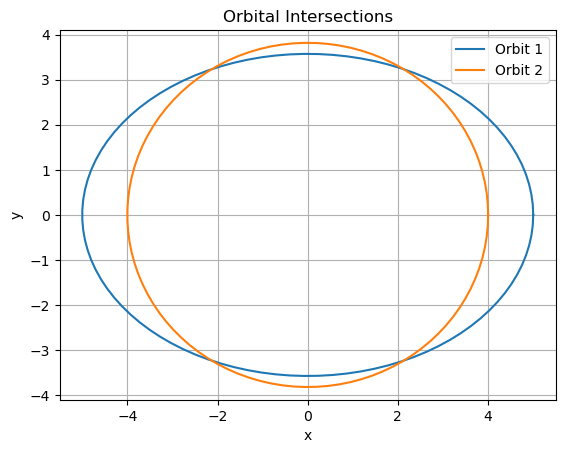

In [9]:
# Parameters: Orbit 1 (a1=3, e1=0.5), Orbit 2 (a2=4, e2=0.3)
a1, e1 = 5, 0.7
b1 = a1 * np.sqrt(1 - e1**2)
a2, e2 = 4, 0.3
b2 = a2 * np.sqrt(1 - e2**2)
roots = []

# System residuals
def residuals(x):
    x, y = z
    f1 = None # = 0
    f2 = None # = 0
    return

# NLLS objective for SHGO (sum squares)
def nlls_obj(z):
    pass
    #res = #
    return # np.sum(np.array(res)**2)

# Local solve with Gauss-Newton, e.g/
#z0 = np.array([1.0, 1.0])
#res_local = least_squares(residuals, z0, method='lm')
#print("Local root:", res_local.x, "Obj:", nlls_obj(res_local.x))

# Global solve with SHGO, suggested to use n=100, iters=5
# bounds = [(-5, 5), (-5, 5)]
# res_global = shgo(nlls_obj, b...)  # Sample densely
# roots = res_global.xl[res_global.funl < 1e-10]  # Filter true zeros
# print("All roots:", roots)

# Plot ellipses and roots
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(a1 * np.cos(theta), b1 * np.sin(theta), '-', label='Orbit 1')
plt.plot(a2 * np.cos(theta), b2 * np.sin(theta), '-', label='Orbit 2')
if len(roots) > 0:
    plt.plot(roots[:,0], roots[:,1], 'ko', label='Roots')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbital Intersections')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 2: DIRECT Method for Global Minimum with Lipschitz Bounds

Use DIRECT (Dividing RECTangles) for derivative-free global opt on a "hidden" black-box function, selecting intervals based on Lipschitz constant bounds. Apply to Branin function (standard test, like optimizing antenna patterns in space comms with unknown noise).

Branin:

$$f(x,y) = (y - \frac{5.1}{4\pi^2} x^2 + \frac{5}{\pi} x - 6)^2 + 10 (1 - \frac{1}{8\pi}) \cos x + 10,$$

bounds [-5,10]x[0,15], Lipschitz constant upper bound ~15 (estimated).
### 2.a
 Use scipy.optimize.direct to minimize, specifying max evaluations (e.g., 200). Print intervals subdivided (access via callback or log).

### 2.b
 Plot the function contours and final intervals/minimum. Vary Lipschitz bound (lipschitz param) and discuss how it affects subdivision (tighter bound focuses on promising regions faster).

Expected Outcome: Global min at ~(-π,12.275), (π,2.275), (9.42,2.475). Show how DIRECT explores without derivatives.
Starter Code:


Global min: [9.42501143 2.47485139] f: 0.3978877388323845


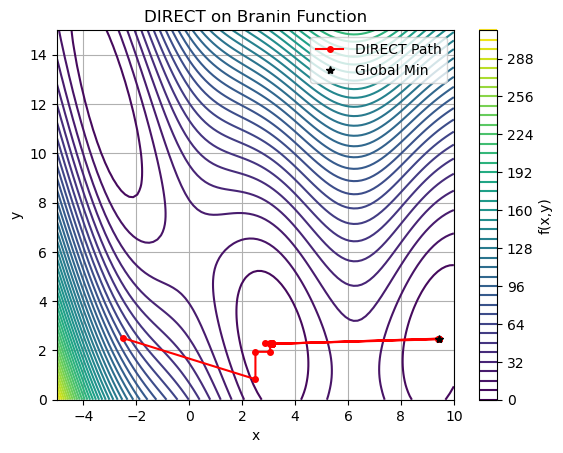

TypeError: direct() got an unexpected keyword argument 'lipschitz'

In [12]:
# Branin function (black-box)
def branin(z):
    x, y = z
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    return a * (y - b * x**2 + c * x - r)**2 + s * (1 - t) * np.cos(x) + s

# Bounds
bounds = Bounds([-5, 0], [10, 15])

# Callback to log iterations (intervals via internal, but print evals)
iter_data = []
def callback(xk, *convergence):
    """Store iteration data for later plotting."""
    # xk is a 1-D array; copy() so further changes inside SciPy do not affect us
    iter_data.append((xk.copy(), branin(xk)))
    # You can optionally inspect / log `convergence` here


# Solve with DIRECT
res = direct(branin, bounds, maxiter=200, callback=callback, len_tol=1e-4)  # Adjust lipschitz if needed, but default None
print("Global min:", res.x, "f:", res.fun)

# Plot contours and path
path = np.array([d[0] for d in iter_data])
x = np.linspace(-5, 10, 100)
y = np.linspace(0, 15, 100)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(lambda x,y: branin([x,y]))(X, Y)

plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.plot(path[:,0], path[:,1], 'r-o', markersize=4, label='DIRECT Path')
plt.plot(res.x[0], res.x[1], 'k*', label='Global Min')
plt.xlabel('x')
plt.ylabel('y')
plt.title('DIRECT on Branin Function')
plt.colorbar(label='f(x,y)')
plt.legend()
plt.grid(True)
plt.show()

# Experiment: Add lipschitz=10 (upper bound) and re-run, compare iterations
res_lip = direct(branin, bounds, maxiter=200, lipschitz=10)
print("With Lipschitz=10:", res_lip.x, "f:", res_lip.fun)

### Exercise 3: MINLP with Penalty Relaxation and SHGO
Solve a Mixed-Integer Non-Linear Program (MINLP) for thruster design: Optimize total thrust efficiency with integer number of thrusters $n \in \{0,1,2,\dots,6\}$ (decision: activate additional units), continuous throttle area $a \in [0.5, 4]$ m².

Model:
Efficiency

$$f = - (n \cdot k \cdot a^{0.8}) / (c + n \cdot d)$$

(thrust output over cost; k=10 efficiency factor, c=5 fixed cost, d=2 per-thruster cost), constraint $n \cdot a \leq 4$ (shared fuel line limit). Goal: Maximize efficiency (min -f).
### 3.a Integer relaxation and solving with SHGO
Relax integer $n$ to continuous with penalty (e.g., add $\mu \sin^2(\pi n)$ to obj for periodicity, $\mu=10$). Use SHGO to solve relaxed problem.

### 3.b.

Plot obj landscape (n vs. a, color=f), show integer points and relaxed solution. Round to nearest integer and verify. Discuss visualization of integer relaxation.


Starter Code:

In [15]:
# Lower and upper bounds for objective function
a_lb = 0.5
a_ub = 4.0
n_lb = 0
n_ub = 6

def obj_unrelaxed(z, mu=0.0):
    n, a = z
    k, c, d = 10, 5, 2
    thrust_eff = n * k * a**0.8
    cost = c + n * d
    #TODO: add penalty for integer relaxation
    return - (thrust_eff / cost)


# Bounds: n [0,3], a [0.5, 4]
bounds = [(n_lb , n_ub), (a_lb, a_ub)]

### Exercise 3 Solution code:

The code below contains the solution to Exercise 3.

Relaxed solution: [1. 4.] Obj: -4.330618761458282
Integer n: 1 a: 4.0


/tmp/ipykernel_278676/1704768151.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(N, A, 4 - N*A, levels=[0], colors='white', linestyles='--', label='Cons: n*a=4')


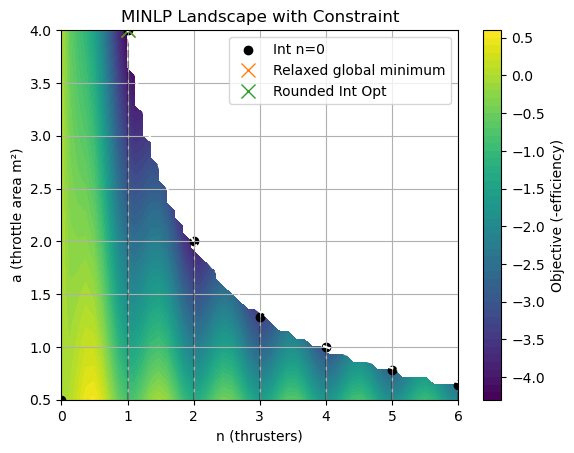

In [50]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import shgo

# Lower and upper bounds for objective function
a_lb = 0.5
a_ub = 4.0
n_lb = 0
n_ub = 6


# Objective with integer relaxation penalty (mu for sin^2(pi n))
def eff_obj(z, mu=1.0):
    n, a = z
    k, c, d = 10, 5, 2
    thrust_eff = n * k * a**0.8
    cost = c + n * d
    int_penalty = mu * np.sin(np.pi * n)**2
    return - (thrust_eff / cost) + int_penalty if cost > 0 else 0

# Inequality constraint: n * a <=4 ⇒ 4 - n*a >=0
def cons_fun(z):
    n, a = z
    return 4 - n * a

constraints = [{'type': 'ineq', 'fun': cons_fun}]

# Bounds: n [0,6], a [0.5,4]
bounds = [(n_lb , n_ub), (a_lb, a_ub)]

# Solve relaxed with SHGO (mu=10, with native constraints)
res = shgo(lambda z: eff_obj(z, mu=1), bounds, constraints=constraints, n=1000, iters=10)
print("Relaxed solution:", res.x, "Obj:", res.fun)

# Round to integer n
n_int = round(res.x[0])
a_opt = res.x[1]
print("Integer n:", n_int, "a:", a_opt)

# Plot landscape (mask infeasible)
n_vals = np.linspace(0, 6, 50)
a_vals = np.linspace(0.5, 4, 50)
N, A = np.meshgrid(n_vals, a_vals)
F = np.vectorize(lambda n,a: eff_obj([n,a]) if n*a <=4 else np.nan)(N, A)  # Mask infeasible

plt.contourf(N, A, F, levels=50, cmap='viridis')
plt.colorbar(label='Objective (-efficiency)')
for ni in range(7):  # Integers 0-6
    a_max = 4 / ni if ni > 0 else 4
    a_valid = a_vals[a_vals <= a_max]
    f_ni = [eff_obj([ni, ai]) for ai in a_valid]
    plt.plot([ni]*len(a_valid), a_valid, 'k--', alpha=0.3)
    if f_ni:
        plt.scatter(ni, a_valid[np.argmin(f_ni)], c='k', label=f'Int n={ni}' if ni==0 else None)

plt.plot(res.x[0], res.x[1], 'x', color='tab:orange', label='Relaxed global minimum', markersize=10)
plt.plot(n_int, a_opt, 'x', color='tab:green', label='Rounded Int Opt', markersize=10)
plt.contour(N, A, 4 - N*A, levels=[0], colors='white', linestyles='--', label='Cons: n*a=4')
plt.xlabel('n (thrusters)')
plt.ylabel('a (throttle area m²)')
plt.title('MINLP Landscape with Constraint')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
res

 message: Optimization terminated successfully.
 success: True
     fun: -4.330618761458282
    funl: [-4.331e+00 -4.331e+00 ... -4.415e-02 -3.805e-02]
       x: [ 1.000e+00  4.000e+00]
      xl: [[ 1.000e+00  4.000e+00]
           [ 1.000e+00  4.000e+00]
           ...
           [ 6.661e-02  6.094e-01]
           [ 6.176e-02  5.547e-01]]
     nit: 10
    nfev: 4156
   nlfev: 905
   nljev: 272
   nlhev: 0

Below is a 3D plot with better visualization of the relaxed landscape:

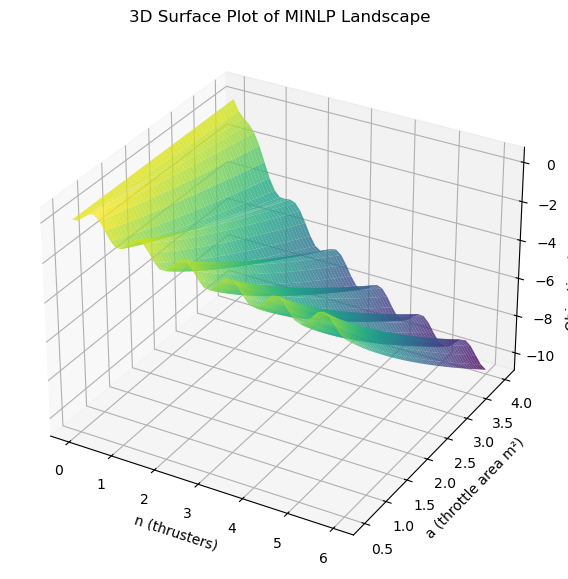

In [22]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define variables from the provided code
a_lb = 0.5
a_ub = 4.0
n_lb = 0
n_ub = 6

def eff_obj(z, mu=1.0):
    n, a = z
    k, c, d = 10, 5, 2
    thrust_eff = n * k * a**0.8
    cost = c + n * d
    penalty = mu * np.sin(np.pi * n)**2  # Integer relaxation
    return - (thrust_eff / cost) + penalty if cost > 0 else 0

# Generate grid
n_vals = np.linspace(n_lb, n_ub, 50)
a_vals = np.linspace(a_lb, a_ub, 50)
N, A = np.meshgrid(n_vals, a_vals)
F = np.vectorize(lambda n,a: eff_obj([n,a]))(N, A)

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(N, A, F, cmap='viridis', alpha=0.8)

# Labels and title
ax.set_xlabel('n (thrusters)')
ax.set_ylabel('a (throttle area m²)')
ax.set_zlabel('Objective (-efficiency)')
ax.set_title('3D Surface Plot of MINLP Landscape')

plt.show()

Note, to understand how the solution can also be found by incorporating the constraint as a penalty, see the code below which incorporates both penalties (integer and constraint) in the objective function.

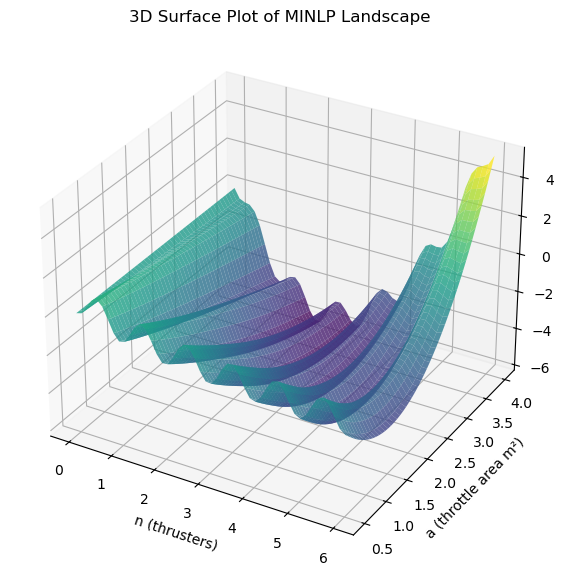

In [31]:
def eff_obj(z, mu=1.5, rho=0.04):
    n, a = z
    k, c, d = 10, 5, 2
    thrust_eff = n * k * a**0.8
    cost = c + n * d
    int_penalty = mu * np.sin(np.pi * n)**2
    cons_penalty = rho * max(0, n * a - 4)**2
    return - (thrust_eff / cost) + int_penalty + cons_penalty if cost > 0 else 0

# Generate grid
n_vals = np.linspace(n_lb, n_ub, 50)
a_vals = np.linspace(a_lb, a_ub, 50)
N, A = np.meshgrid(n_vals, a_vals)
F = np.vectorize(lambda n,a: eff_obj([n,a]))(N, A)

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(N, A, F, cmap='viridis', alpha=0.8)

# Labels and title
ax.set_xlabel('n (thrusters)')
ax.set_ylabel('a (throttle area m²)')
ax.set_zlabel('Objective (-efficiency)')
ax.set_title('3D Surface Plot of MINLP Landscape')

plt.show()

## Exercise 4: Finding and Characterizing Lagrange Points in the Earth-Sun System


In the circular restricted three-body problem (CR3BP), a third body (e.g., a spacecraft) moves under the gravitational influence of two massive bodies (e.g., Earth and Sun) in circular orbits around their common center of mass. The Lagrange points are five equilibrium solutions where the third body can remain stationary relative to the two primaries. These points are critical in space engineering for missions like satellite placement (e.g., at L1 for solar observation).
This exercise builds on Chapter 3 (non-linearity and chaos in dynamical systems), Chapter 5 (simulation of ODE systems), and Chapter 9 (global optimization with SHGO). You will:

Use SHGO to find all Lagrange points at once by globally minimizing the squared norm of the gradient of the effective potential (since equilibria are critical points where $\nabla U = 0$, and SHGO finds all local minima of $\|\nabla U\|^2$).
Characterize their stability by linearizing the dynamics and analyzing eigenvalues (relating to chaotic behavior if unstable).
Simulate perturbed orbits around selected points to visualize stability (using ODE integration).

Use the non-dimensional CR3BP equations, with mass ratio $\mu = m_2 / (m_1 + m_2)$ where $m_1$ is Sun, $m_2$ is Earth ($\mu \approx 3 \times 10^{-6}$).

#### Theory Recap

The effective potential in CR3BP is $U(x,y) = \frac{1}{2}(x^2 + y^2) + \frac{1-\mu}{r_1} + \frac{\mu}{r_2}$, where $r_1 = \sqrt{(x + \mu)^2 + y^2}$, $r_2 = \sqrt{(x - 1 + \mu)^2 + y^2}$.
Equilibria satisfy $\nabla U = 0$ (zero acceleration in rotating frame). To find all with SHGO, minimize $f(x,y) = \|\nabla U(x,y)\|^2$, where minima of 0 are the equilibria.

The state-space dynamics (for simulation): $\ddot{x} = 2\dot{y} + \frac{\partial U}{\partial x}$, $\ddot{y} = -2\dot{x} + \frac{\partial U}{\partial y}$.

Stability: Linearize around equilibrium $\mathbf{x}^*$ to get $\dot{\mathbf{\delta}} = A \mathbf{\delta}$, where $A$ is the Jacobian. If all eigenvalues have negative real parts, stable; positive real parts indicate instability (saddles common in CR3BP).

### 4.a Find All Lagrange Points with SHGO

1. Set up the squared gradient norm $f(x,y) = U_x^2 + U_y^2$.
2. Use SHGO over a bounded domain (e.g., $[-2, 2] \times [-2, 2]$) to find all minima (res.xl where funl ≈ 0).

>HINT: Because this objective function is a valley function, you will need to filter out the non-convex points where $f$ is far from zero.

### 4.b: Characterize Stability
Compute the Jacobian $A$ at each point:
$$A = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
U_{xx} & U_{xy} & 0 & 2 \\
U_{xy} & U_{yy} & -2 & 0
\end{bmatrix}$$
Where second derivatives from $U$.

### 4.c Simulate and Visualize Orbits

Perturb each point slightly and integrate the ODEs to observe behavior (stable: bounded; unstable: divergence).

Stub code:

In [ ]:
import numpy as np
from scipy.optimize import shgo
import matplotlib.pyplot as plt

mu = 3.003e-6  # Earth-Sun mass ratio

def U_grad(x_y):
    x, y = x_y
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    Ux = x - (1 - mu) * (x + mu) / r1**3 - mu * (x - 1 + mu) / r2**3
    Uy = y - (1 - mu) * y / r1**3 - mu * y / r2**3
    return Ux, Uy

### Solution code for Exercise 4:

Filtered and top 5 Lagrange points:
 [[-1.00000125e+00  1.23487670e-14]
 [ 5.01737076e-01 -8.65018440e-01]
 [ 5.01737163e-01  8.65018380e-01]
 [ 9.90027117e-01 -2.57112277e-24]
 [ 1.01003358e+00  3.26951978e-09]]


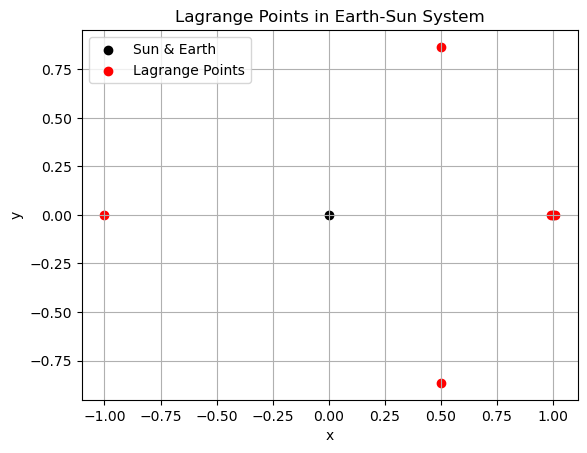

In [84]:
import numpy as np
from scipy.optimize import shgo
import matplotlib.pyplot as plt

mu = 3.003e-6  # Earth-Sun mass ratio

def U_grad(x_y):
    x, y = x_y
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    Ux = x - (1 - mu) * (x + mu) / r1**3 - mu * (x - 1 + mu) / r2**3
    Uy = y - (1 - mu) * y / r1**3 - mu * y / r2**3
    return Ux, Uy

def grad_norm_squared(x_y):
    Ux, Uy = U_grad(x_y)
    return Ux**2 + Uy**2

bounds = [(-2, 2), (-2, 2)]

# Run SHGO with sufficient sampling for refinement
res = shgo(grad_norm_squared, bounds, n=3e6, iters=1)  # n: samples/iter, iters: refinement levels

# Filter points near zero norm (true equilibria)
near_zero_mask = np.isclose(res.funl, 0, atol=1e-10)
filtered_xl = res.xl[near_zero_mask]
filtered_funl = res.funl[near_zero_mask]

# Select top 5 with lowest funl (best approximations to zero)
sorted_idx = np.argsort(filtered_funl)[:5]
equilibria = filtered_xl[sorted_idx]

# Optional: Deduplicate if close (e.g., numerical duplicates)
unique_idx = np.unique(np.round(equilibria, decimals=4), axis=0, return_index=True)[1]
equilibria = equilibria[unique_idx]

print("Filtered and top 5 Lagrange points:\n", equilibria)

# Plot points with primaries
plt.scatter([-mu, 1 - mu], [0, 0], color='k', label='Sun & Earth')
plt.scatter(equilibria[:, 0], equilibria[:, 1], color='r', label='Lagrange Points')
plt.title('Lagrange Points in Earth-Sun System')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
res

 message: Optimization terminated successfully.
 success: True
     fun: 5.3740028696787734e-18
    funl: [ 5.374e-18  2.094e-16 ...  1.227e-04  1.227e-04]
       x: [-1.000e+00  1.235e-14]
      xl: [[-1.000e+00  1.235e-14]
           [ 5.017e-01 -8.650e-01]
           ...
           [ 9.903e-01 -3.906e-03]
           [ 9.903e-01  3.906e-03]]
     nit: 1
    nfev: 3006876
   nlfev: 6876
   nljev: 2037
   nlhev: 0

In [ ]:
# Task 2:

def jacobian(point):
    x, y = point
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    Uxx = 1 - (1 - mu)/r1**3 + 3*(1 - mu)*(x + mu)**2/r1**5 - mu/r2**3 + 3*mu*(x - 1 + mu)**2/r2**5
    Uxy = 3*(1 - mu)*(x + mu)*y/r1**5 + 3*mu*(x - 1 + mu)*y/r2**5
    Uyy = 1 - (1 - mu)/r1**3 + 3*(1 - mu)*y**2/r1**5 - mu/r2**3 + 3*mu*y**2/r2**5
    return np.array([[0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [Uxx, Uxy, 0, 2],
                     [Uxy, Uyy, -2, 0]])

# For each equilibrium
for i, point in enumerate(equilibria):
    eigs = np.linalg.eigvals(jacobian(point))
    print(f"Point {i+1} {point}: eigenvalues {eigs}")
    # Classify: unstable if any Re(eig) > 0

In [ ]:
# Task 3: Simulate orbits near equilibria

from scipy.integrate import solve_ivp

def cr3bp_dynamics(t, state):
    x, y, vx, vy = state
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    ax = 2*vy + x - (1 - mu)*(x + mu)/r1**3 - mu*(x - 1 + mu)/r2**3
    ay = -2*vx + y - (1 - mu)*y/r1**3 - mu*y/r2**3
    return [vx, vy, ax, ay]

# Example: Perturb first equilibrium (e.g., L1)
eq = equilibria[0]  # Change index for others
init = [eq[0] + 1e-3, eq[1] + 1e-3, 0, 0]
sol = solve_ivp(cr3bp_dynamics, [0, 10], init, rtol=1e-12)

plt.plot(sol.y[0], sol.y[1])
plt.scatter([-mu, 1 - mu], [0, 0], color='k', label='Primaries')
plt.scatter(eq[0], eq[1], color='r', label='Equilibrium')
plt.title('Orbit near Equilibrium (Unstable Example)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Repeat for a stable point (e.g., L4: expect bounded Lissajous orbit)

### Improving the Objective Function for Lagrange Points Search

The current objective function $f(x,y) = U_x^2 + U_y^2$ (squared L2 norm of the gradient) creates parabolic valleys around the equilibria (where $f=0$), which are relatively smooth and wide. This can make it harder for global optimizers like SHGO to distinguish and converge precisely to the true zeros, especially in flat or low-gradient regions, requiring high sampling (n ≥ 2e6) to resolve all five points reliably.

To improve, we can use the unsquared L2 norm $f(x,y) = \sqrt{U_x^2 + U_y^2}$ or the L1 norm $f(x,y) = |U_x| + |U_y|$. These create sharper, "V-shaped" or cone-like valleys at the minima, amplifying the "penalty" away from zero and making the minima more pronounced for the optimizer to detect with fewer samples. The L1 norm is particularly sharp (less differentiable but effective for global search). This doesn't change the locations of minima but steepens the landscape, reducing the need for excessive sampling.

Additionally, tighten the search bounds to $[-1.5, 1.5] \times [-1, 1]$ (covering known Lagrange point locations) to focus computation and reduce n to ~1e5–5e5 for similar accuracy.


Lagrange points:
 [[-9.99980435e-01 -6.45250719e-03]
 [-1.00000125e+00 -1.82730875e-05]
 [-9.99978824e-01  6.69730597e-03]
 [ 4.99437565e-01 -8.66348156e-01]
 [ 4.99443831e-01  8.66344527e-01]]


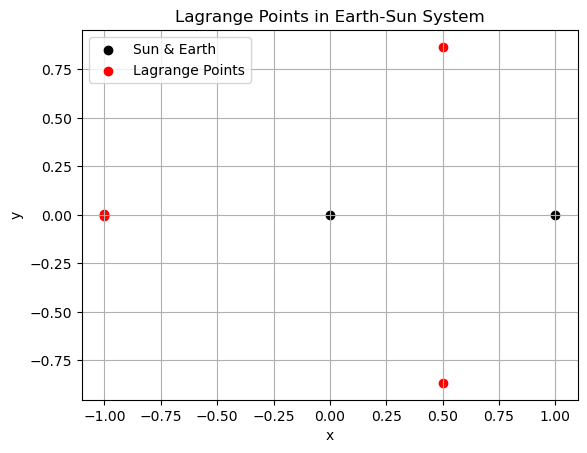

In [6]:
import numpy as np
from scipy.optimize import shgo
import matplotlib.pyplot as plt

mu = 3.003e-6  # Earth-Sun mass ratio

def U_grad(x_y):
    x, y = x_y
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    Ux = x - (1 - mu) * (x + mu) / r1**3 - mu * (x - 1 + mu) / r2**3
    Uy = y - (1 - mu) * y / r1**3 - mu * y / r2**3
    return Ux, Uy

def grad_norm_l1(x_y):
    Ux, Uy = U_grad(x_y)
    return np.abs(Ux) + np.abs(Uy)  # Sharper L1 norm

bounds = [(-1.5, 1.5), (-1, 1)]  # Tighter bounds

# Run SHGO
res = shgo(grad_norm_l1, bounds, n=100000, iters=1, sampling_method='sobol')

# Filter and select top 5
near_zero_mask = np.isclose(res.funl, 0, atol=1e-5)
filtered_xl = res.xl[near_zero_mask]
filtered_funl = res.funl[near_zero_mask]
sorted_idx = np.argsort(filtered_funl)[:5]
equilibria = filtered_xl[sorted_idx]

# Deduplicate
unique_idx = np.unique(np.round(equilibria, decimals=4), axis=0, return_index=True)[1]
equilibria = equilibria[unique_idx]

print("Lagrange points:\n", equilibria)

# Plot
plt.scatter([-mu, 1 - mu], [0, 0], color='k', label='Sun & Earth')
plt.scatter(equilibria[:, 0], equilibria[:, 1], color='r', label='Lagrange Points')
plt.title('Lagrange Points in Earth-Sun System')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
res

 message: Optimization terminated successfully.
 success: True
     fun: 1.0300229000331096e-07
    funl: [ 1.030e-07  2.656e-07 ...  3.917e-04  1.259e-03]
       x: [-9.993e-01 -3.748e-02]
      xl: [[-9.993e-01 -3.748e-02]
           [ 4.682e-01  8.836e-01]
           ...
           [ 9.961e-01  8.757e-02]
           [ 9.988e-01 -4.884e-02]]
     nit: 1
    nfev: 26695
   nlfev: 18503
   nljev: 2064
   nlhev: 0

# (Optional mini project) Exercise 5: Geometry Optimization of fin shapes for Re-Entry Vehicles

Recall from Chapter 6 we conducted a simulation of a probe with a a fin added to reduce the turbulence and drag forces during re-entry. In this exercise will extend that simulation to optimize the fin length.

## 5.a Objective function formulation

Based on the simulation result from Chapter 6, define an objective function based on the derived criteria. Scale the outputs so that the objective function will behave appropriately with respect to material cost and performance (e.g., drag reduction).

> HINT: This objective function is expected to have a relatively noisy output even at equilibrium due to the non-linear fluid dynamics simulation. There do not expect to find a "perfect" solution for the fin length. Instead you are looking for a "good enough" solution that balances performance and cost and defining what that means in the objective function is precisely the goal of this part of the exercise.

## 5.b Optimization using SHGO

Wrap the code below into an objective function that takes fin length as input and returns the objective value. Use SHGO to find the optimal fin length within a reasonable range (e.g., 10 to 100 lattice units).

## 5.c Results

Plot the final result of your optimized probe.

## 5.d Discussion

Play around with the simulation, e.g. change the atmospheric viscosity, inflow speed, or grid resolution. Discuss how these changes affect the optimal fin length and the overall performance of the probe in different scenarios.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
nx, ny = 400, 100  # Grid size
cx, cy, r = nx//5, ny//2, ny//10  # Cylinder position and radius
u_in_max = 0.01  # Even lower for stability
u_in_max = 0.1 # Higher to see vortex shedding
u_in_max = 0.4 # Higher to see vortex shedding
nu = 0.02  # Increased for more viscosity
tau = 3*nu + 0.5  # Relaxation time
#nt = 20000  # Time steps
nt = 4000  # Time steps
plot_every = 200
dx = 1.0  # Lattice spacing
fin_length = 50  # Trailing fin length (lattice units; adjustable)

# LBM setup (D2Q9)
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])  # Weights
cx_lbm = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])  # x velocities
cy_lbm = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])  # y velocities

# Initialize distributions with uniform flow equilibrium
def equilibrium(rho, ux, uy):
    ux = np.clip(ux, -0.3, 0.3)
    uy = np.clip(uy, -0.3, 0.3)
    if np.isscalar(rho):
        rho = np.array([rho])
        ux = np.array([ux])
        uy = np.array([uy])
    rho = np.asanyarray(rho)
    ux = np.asanyarray(ux)
    uy = np.asanyarray(uy)

    shape = rho.shape
    rho_flat = rho.flatten()
    ux_flat = ux.flatten()
    uy_flat = uy.flatten()
    n = len(rho_flat)

    cu = 3 * (np.tile(cx_lbm[:, None], (1, n)) * np.tile(ux_flat[None, :], (9, 1)) +
              np.tile(cy_lbm[:, None], (1, n)) * np.tile(uy_flat[None, :], (9, 1)))
    uu = 3/2 * (ux_flat**2 + uy_flat**2)
    feq_flat = np.tile(w[:, None], (1, n)) * np.tile(rho_flat[None, :], (9, 1)) * (1 + cu + 0.5*cu**2 - np.tile(uu[None, :], (9, 1)))
    feq_flat = np.nan_to_num(feq_flat)
    feq = feq_flat.reshape(9, *shape)
    return feq

f = equilibrium(np.ones((nx,ny)), np.ones((nx,ny))*0.001, np.zeros((nx,ny)))  # Small initial u for equilibrium

# Cylinder mask
X, Y = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
obstacle = (X - cx)**2 + (Y - cy)**2 <= r**2

# Add trailing fin: horizontal line at y=cy, from x = cx + r to cx + r + fin_length
fin_start_x = cx + r
fin_end_x = cx + r + fin_length
fin = (Y == cy) & (X >= fin_start_x) & (X <= fin_end_x)
obstacle = obstacle | fin

def collide(f, rho, ux, uy):
    feq = equilibrium(rho, ux, uy)
    return f - (f - feq) / tau

def stream(f):
    for i in range(1, 9):
        f[i] = np.roll(f[i], shift=(cx_lbm[i], cy_lbm[i]), axis=(0, 1))
    return f

def bounce_back(f, obstacle):
    opp = [0, 3, 4, 1, 2, 7, 8, 5, 6]  # Opposite directions
    f_temp = f.copy()
    for i in range(1, 9):
        f[i, obstacle] = f_temp[opp[i], obstacle]
    return f

def apply_inlet_outlet(f, rho, ux, uy, u_in_current):
    # Inlet (left): Equilibrium BC for smoother
    feq_left = equilibrium(1.0, u_in_current, 0.0)
    f[:, 0, :] = feq_left.squeeze()[:, None]
    # Outlet (right): copy
    f[:, -1, :] = f[:, -2, :]
    return f

def apply_sponge(f, rho, ux, uy):
    # Sponge at outlet (last 20 columns): relax to equilibrium
    sponge_start = nx - 20
    for i in range(sponge_start, nx):
        sigma = (i - sponge_start) / 20.0  # Linear damping
        feq = equilibrium(rho[i, :], ux[i, :], uy[i, :])
        f[:, i, :] = f[:, i, :] * (1 - sigma) + feq * sigma
    return f

# Simulation loop
for t in range(nt):
    # Stream
    f = stream(f)

    # Boundaries
    f = bounce_back(f, obstacle)

    # Macroscopic variables
    rho = np.sum(f, axis=0)
    rho = np.clip(rho, 0.1, 10.0)
    ux = np.sum(f * cx_lbm[:, None, None], axis=0) / rho
    uy = np.sum(f * cy_lbm[:, None, None], axis=0) / rho

    # Ramp inlet velocity (longer ramp)
    u_in_current = u_in_max * min(1.0, t / 1000.0)

    f = apply_inlet_outlet(f, rho, ux, uy, u_in_current)
    f = apply_sponge(f, rho, ux, uy)

    # Collide
    f = collide(f, rho, ux, uy)

    # Wait for the flow to develop before plotting
    if t > 1000:
        if t % plot_every == 0 and t > 0:
            vorticity = (np.roll(uy, -1, axis=0) - np.roll(uy, 1, axis=0)) / (2*dx) - \
                        (np.roll(ux, -1, axis=1) - np.roll(ux, 1, axis=1)) / (2*dx)
            velocity_mag = np.sqrt(ux**2 + uy**2)

            # Downstream region for metrics (x from fin_end_x to nx-50, full y)
            downstream_start = int(fin_end_x) if 'fin_end_x' in locals() else nx//2
            downstream = slice(downstream_start, nx-50)
            vort_mag_down = np.mean(np.abs(vorticity[downstream, :]))
            vel_var_down = np.var(ux[downstream, :] + uy[downstream, :])  # TKE proxy (variance of velocity components)
            print(f"t={t}: Downstream Avg Vorticity Mag = {vort_mag_down:.4f}, TKE Proxy = {vel_var_down:.4f}")

            # Cylinder drag (simple approximation: integrate x-momentum loss around cylinder)
            cyl_slice = slice(cx - r - 5, cx + r + 5)
            drag_approx = np.sum(rho[cyl_slice, :] * ux[cyl_slice, :] * dx)  # Proxy for drag (momentum flux)
            print(f"t={t}: Cylinder Drag Proxy = {drag_approx:.4f}")

            fig, axs = plt.subplots(1, 2, figsize=(12, 4))

            # Velocity magnitude
            im0 = axs[0].imshow(velocity_mag.T, origin='lower', cmap='RdBu', vmin=0, vmax=u_in_max*1.5)
            axs[0].set_title('Velocity Magnitude')
            fig.colorbar(im0, ax=axs[0])

            # Add black lines for cylinder and fin
            circle = plt.Circle((cx, cy), r, color='black', fill=False, linewidth=2)
            axs[0].add_patch(circle)
            axs[0].hlines(cy, fin_start_x, fin_end_x, colors='black', linewidth=2)

            # Vorticity
            im1 = axs[1].imshow(vorticity.T, origin='lower', cmap='RdBu', vmin=-0.1, vmax=0.1)
            axs[1].set_title('Vorticity')
            fig.colorbar(im1, ax=axs[1])

            # Add black lines for cylinder and fin
            circle = plt.Circle((cx, cy), r, color='black', fill=False, linewidth=2)
            axs[1].add_patch(circle)
            axs[1].hlines(cy, fin_start_x, fin_end_x, colors='black', linewidth=2)

            fig.suptitle(f't = {t}')
            plt.show()